<a href="https://colab.research.google.com/github/vainaijr/Attention-Augmented-Conv2d/blob/master/few_shot_attention_hierarchy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext tensorboard
%tensorboard --logdir=runs

In [0]:
import torch , torch.nn as nn, torchvision, torchvision.transforms as transforms, torchsummary
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 100
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Files already downloaded and verified


In [0]:
next(iter(train_loader))[1].shape 

torch.Size([100])

In [0]:
len(train_loader)

500

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)


In [0]:
writer = SummaryWriter()

In [0]:
# Simple Conv Block
class ConvBlock(nn.Module):
    maml = False #Default
    def __init__(self, indim, outdim, pool = True, padding = 1):
        super(ConvBlock, self).__init__()
        self.indim  = indim
        self.outdim = outdim
        self.C      = nn.Conv2d(indim, outdim, 3, padding= padding)
        self.BN     = nn.BatchNorm2d(outdim)
        self.relu   = nn.ReLU(inplace=True)

        self.parametrized_layers = [self.C, self.BN, self.relu]
        
        self.pool   = nn.MaxPool2d(2)
        self.parametrized_layers.append(self.pool)

        self.trunk = nn.Sequential(*self.parametrized_layers)


    def forward(self,x):
        out = self.trunk(x)
        return out


In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        # set_trace()
        return x.view(x.size(0), -1)

In [0]:
level_one = [torchvision.models.alexnet(pretrained=False) for i in range(4)]

In [0]:
class CombineBase(nn.Module):
  def __init__(self, ModelOne, ModelTwo):
    super().__init__()
    self.modelone = ModelOne.to('cuda')
    self.modeltwo = ModelTwo.to('cuda')
    self.lin_one = nn.Linear(2000, 1000)
    self.lin_two = nn.Linear(1000, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, x):
    out = torch.cat((self.modelone(x), self.modeltwo(x)), dim=-1)
    out = self.softmax(self.lin_two(self.lin_one(out)))
    return out

class CombineMiddle(nn.Module):
  def __init__(self, ModelOne, ModelTwo):
    super().__init__()
    self.modelone = ModelOne
    self.modeltwo = ModelTwo
    self.lin = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, x):
    out = torch.cat((self.modelone(x), self.modeltwo(x)), dim=-1)
    out = self.softmax(self.lin(out))
    return out

In [0]:
level_two = [CombineBase(level_one[i], level_one[i+1]) for i in range(4) if i%2 == 0]

RuntimeError: ignored

In [0]:
len(level_two)

8

In [0]:
level_three = [CombineMiddle(level_two[i], level_two[i+1]) for i in range(8) if i%2 == 0]

In [0]:
len(level_three)

4

In [0]:
level_four = [CombineMiddle(level_three[i], level_three[i+1]) for i in range(4) if i%2 == 0]

In [0]:
len(level_four)

2

In [0]:
top_level = CombineMiddle(level_four[0], level_four[1])

In [0]:
torchsummary.summary(top_level, (3, 128, 128), batch_size=100)

RuntimeError: ignored

In [0]:
x = Combine(*x)

In [0]:
class NetA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(2500, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 2500)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        print('A', x.shape)
        return x

class NetB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(2500, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 2500)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        print('B', x.shape)
        return x


class NetC(nn.Module): #Relation net use a 4 layer conv with pooling in only first two layers, else no pooling
    def __init__(self):
        super().__init__()
        trunk = []
        for i in range(4):
            indim = 3 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i in [0,1] ), padding = 0 if i in[0,1] else 1  ) #only first two layer has pooling and no padding
            trunk.append(B)
        trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64
        self.classifier = nn.Linear(self.final_feat_dim, 10)
        self.softmax = nn.Softmax(dim=-1)



    def forward(self,x):
        out = self.trunk(x)
        # plt.imshow(out)
    # show_image(out)
        out = self.classifier(out)
        return ((out))

class NetD(nn.Module): #Relation net use a 4 layer conv with pooling in only first two layers, else no pooling
    def __init__(self):
        super().__init__()
        trunk = []
        for i in range(4):
            indim = 3 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i in [0,1] ), padding = 0 if i in[0,1] else 1  ) #only first two layer has pooling and no padding
            trunk.append(B)
        trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64
        self.classifier = nn.Linear(self.final_feat_dim, 10)
        self.softmax = nn.Softmax(dim=-1)



    def forward(self,x):
        out = self.trunk(x)
        # plt.imshow(out)
    # show_image(out)
        out = self.classifier(out)
        return ((out))

class NetE(nn.Module): #Relation net use a 4 layer conv with pooling in only first two layers, else no pooling
    def __init__(self):
        super().__init__()
        trunk = []
        for i in range(4):
            indim = 3 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i in [0,1] ), padding = 0 if i in[0,1] else 1  ) #only first two layer has pooling and no padding
            trunk.append(B)
        trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64
        self.classifier = nn.Linear(self.final_feat_dim, 10)
        self.softmax = nn.Softmax(dim=-1)



    def forward(self,x):
        out = self.trunk(x)
        # plt.imshow(out)
    # show_image(out)
        out = self.classifier(out)
        return ((out))

class NetF(nn.Module): #Relation net use a 4 layer conv with pooling in only first two layers, else no pooling
    def __init__(self):
        super().__init__()
        trunk = []
        for i in range(4):
            indim = 3 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i in [0,1] ), padding = 0 if i in[0,1] else 1  ) #only first two layer has pooling and no padding
            trunk.append(B)
        trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64
        self.classifier = nn.Linear(self.final_feat_dim, 10)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x):
        out = self.trunk(x)
        # plt.imshow(out)
    # show_image(out)
        out = self.classifier(out)
        return ((out))

class NetG(nn.Module): #Relation net use a 4 layer conv with pooling in only first two layers, else no pooling
    def __init__(self):
        super().__init__()
        trunk = []
        for i in range(4):
            indim = 3 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i in [0,1] ), padding = 0 if i in[0,1] else 1  ) #only first two layer has pooling and no padding
            trunk.append(B)
        trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64
        self.classifier = nn.Linear(self.final_feat_dim, 10)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self,x):
        out = self.trunk(x)
        # plt.imshow(out)
    # show_image(out)
        out = self.classifier(out)
        return ((out))

class NetH(nn.Module): #Relation net use a 4 layer conv with pooling in only first two layers, else no pooling
    def __init__(self):
        super().__init__()
        trunk = []
        for i in range(4):
            indim = 3 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i in [0,1] ), padding = 0 if i in[0,1] else 1  ) #only first two layer has pooling and no padding
            trunk.append(B)
        trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64
        self.classifier = nn.Linear(self.final_feat_dim, 10)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x):
        out = self.trunk(x)
        # plt.imshow(out)
    # show_image(out)
        out = self.classifier(out)
        return ((out))

class NetAB(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetA().to(device)
    self.ModelTwo = NetB().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.softmax(self.fc(out))

class NetCD(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetC().to(device)
    self.ModelTwo = NetD().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.softmax(self.fc(out))

class NetEF(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetE().to(device)
    self.ModelTwo = NetF().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.softmax(self.fc(out))

class NetGH(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetG().to(device)
    self.ModelTwo = NetH().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.softmax(self.fc(out))

class NetABCD(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetAB().to(device)
    self.ModelTwo = NetCD().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.softmax(self.fc(out))

class NetEFGH(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetEF().to(device)
    self.ModelTwo = NetGH().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.softmax(self.fc(out))

class NetABCDEFGH(nn.Module):
  def __init__(self):
    super().__init__()
    self.ModelOne = NetABCD().to(device)
    self.ModelTwo = NetEFGH().to(device)
    self.fc = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self, inp):
    out = torch.cat((self.ModelOne(inp), self.ModelTwo(inp)), dim=-1)
    # print('convnetonetwo', out.shape)
    return self.fc(out)

model = NetABCDEFGH().to(device)

def hook(module, input, output):
  print(input[0].shape, output.shape)
  print(module)
  grid = torchvision.utils.make_grid(output[0][0])
  writer.add_image('conv_features', grid, 0)

hookA = model.ModelOne.ModelOne.ModelTwo.conv2.register_forward_hook(hook)
# hookB = NetB().register_forward_hook(hook)


In [0]:
torchsummary.summary(model, (3, 32, 32), 100)

A torch.Size([1, 10])
torch.Size([2, 20, 14, 14]) torch.Size([2, 50, 10, 10])
Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
B torch.Size([1, 10])


RuntimeError: ignored

In [0]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print('predicted:', predicted)
        print('labels:', labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

torch.Size([100, 64, 4, 4]) torch.Size([100, 64, 2, 2])
ConvBlock(
  (C): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (trunk): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([100, 64, 4, 4]) torch.Size([100, 64, 2, 2])
ConvBlock(
  (C): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (trunk): Sequential(
   

In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [0]:
writer.add_image

In [0]:
import torchvision, torch.nn as nn, torch, torchsummary, numpy as np
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

# Hyper parameters
num_epochs = 100
num_classes = 1
batch_size = 100
learning_rate = 0.001
print(torch.__version__)
# MNIST dataset
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10/',
                                           train=True,
                                           transform=transforms.Compose([transforms.Normalize(mean= [0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225]),
                                                                         transforms.ToTensor()
                                                                      ]),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./cifar10/',
                                          train=False,
                                          transform=transforms.Compose([transforms.Normalize(mean= [0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225]),
                                                                        transforms.ToTensor()
                                                                        ]))

indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
valid_size = 0.2
split = int(np.floor(valid_size * len(train_dataset)))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler, num_workers=0)

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


class Combine(nn.Module):
  def __init__(self, ModelOne, ModelTwo):
    super().__init__()
    self.modelone = ModelOne
    self.modeltwo = ModelTwo
    self.linear = nn.Linear(20, 10)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    out = torch.cat((self.modelone(x), self.modeltwo(x)), dim=-1)
    out = self.softmax(self.linear((out)))
    return out

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


class Convnet(nn.Module):
    def __init__(self, x_dim=3, hid_dim=32, z_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
        )
        self.lin_one = nn.Linear(8192, 100)
        self.lin_two = nn.Linear(100, 10)
        self.out_channels = 1600

    def forward(self, x):
        x = self.encoder(x)
        return self.lin_two(self.lin_one(x.view(x.size(0), -1)))

level_one = [Convnet() for i in range(4)]

def one_level(combination_type, number, level):
    return [combination_type(level[i], level[i+1]) for i in range(number) if i%2==0]

# def hook(module, input, output):
#     set_trace()
#     print(module, input[0].shape, output.shape)

# x = model.CombineMiddle.CombineMiddle.CombineBase.modelone.features[12].register_forward_hook(hook)

level_two = one_level(Combine, 4, level_one)
# level_three = one_level(CombineMiddle, 4, level_two)
# level_four = one_level(CombineMiddle, 4, level_three)
# top_level = CombineMiddle(level_three[0], level_three[1]).to('cuda')
model = Combine(level_two[0], level_two[1])
model.to('cuda')
torchsummary.summary(model, (3, 32, 32), batch_size=100)

writer = SummaryWriter()
def hook(module, input, output):
    print(input[0].shape, output.shape)
    grid = torchvision.utils.make_grid(output)
    grid = grid[None, :]
    print(grid.shape)
    writer.add_images('conv_features', grid)

a = model.modelone.modelone.encoder.register_forward_hook(hook)
b = model.modelone.modeltwo.encoder.register_forward_hook(hook)
c = model.modeltwo.modelone.encoder.register_forward_hook(hook)
d = model.modeltwo.modeltwo.encoder.register_forward_hook(hook)
# model = top_level

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# number of epochs to train the model

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(num_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    total_step = len(train_loader)
    model.train() # prep model for training
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
        
    ######################    
    # validate the model #
    ######################
    total_step = len(valid_loader)
    model.eval() # prep model for evaluation
    for i, (data, target) in enumerate(valid_loader):
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
            

# Test the model
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    data, target = data.to('cuda'), target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {str(i)}: {(100 * class_correct[i] / class_total[i]):.2f} \
        ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'\nTest Accuracy (Overall): {(100. * np.sum(class_correct) / np.sum(class_total)):.2f} \
       ({np.sum(class_correct)}/{np.sum(class_total)})')

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to('cuda'), labels.to('cuda')
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
# images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))
    
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


1.1.0
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 32, 32, 32]             896
       BatchNorm2d-2          [100, 32, 32, 32]              64
              ReLU-3          [100, 32, 32, 32]               0
         MaxPool2d-4          [100, 32, 16, 16]               0
            Linear-5                 [100, 100]         819,300
            Linear-6                  [100, 10]           1,010
           Convnet-7                  [100, 10]               0
            Conv2d-8          [100, 32, 32, 32]             896
       BatchNorm2d-9          [100, 32, 32, 32]              64
             ReLU-10          [100, 32, 32, 32]               0
        MaxPool2d-11          [100, 32, 16, 16]               0
           Linear-12                 [100, 100]         819,300
           Linear-13                  [100, 10]           1

TypeError: ignored

In [0]:
print(id(level_one[0]), id(level_one[1]), id(level_one[2]), id(level_one[3]),
      id(level_two[0]), id(level_two[1]), id(model))

140706170054136 140706125226952 140706125229416 140706097772360 140706107412376 140706097844688 140706170054080


In [0]:
level_one[0] is level_one[1]

True

In [0]:
model

Combine(
  (modelone): Convnet(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3)

In [0]:
!pip install flashtorch

  Created wheel for flashtorch: filename=flashtorch-0.1.0-cp36-none-any.whl size=28576 sha256=20aed85d4ef8e453ab7ab5f3c9a2c872ce6f281d21c07a2ca3fc7cc7c863ef25
  Stored in directory: /root/.cache/pip/wheels/b1/ca/ce/774a0c57a863f51ee8126ba22e75d5f5ed40f5c02d5862068e
Successfully built flashtorch


In [0]:
!pip install flashtorch

  Created wheel for flashtorch: filename=flashtorch-0.1.0-cp36-none-any.whl size=28576 sha256=1d1231f5c54fef523c8232ae79e84a85a0489cbdef99548347e82085195d341d
  Stored in directory: /root/.cache/pip/wheels/b1/ca/ce/774a0c57a863f51ee8126ba22e75d5f5ed40f5c02d5862068e
Successfully built flashtorch


In [0]:
!git clone https://github.com/leaderj1001/Attention-Augmented-Conv2d.git

Cloning into 'Attention-Augmented-Conv2d'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 171 (delta 83), reused 60 (delta 25), pack-reused 0
Receiving objects: 100% (171/171), 41.63 KiB | 249.00 KiB/s, done.
Resolving deltas: 100% (83/83), done.


In [0]:
%cd Attention-Augmented-Conv2d/

/content/Attention-Augmented-Conv2d


In [1]:
!git clone https://github.com/leaderj1001/Stand-Alone-Self-Attention.git

Cloning into 'Stand-Alone-Self-Attention'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 129 (delta 63), reused 44 (delta 15), pack-reused 0
Receiving objects: 100% (129/129), 89.96 MiB | 28.27 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
%cd Stand-Alone-Self-Attention/

/content/Stand-Alone-Self-Attention


In [3]:
!ls

attention.py  config.py  LICENSE  main.py  model.py  preprocess.py  README.md


In [0]:
!cat attention.py

In [0]:
class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        set_trace()
        batch, channels, height, width = x.size()
        # x.shape -> torch.Size([2, 3, 32, 32])

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        # padded_x.shape -> torch.Size([2, 3, 34, 34])
        q_out = self.query_conv(padded_x)
        # q_out.shape -> torch.Size([2, 16, 32, 32])
        k_out = self.key_conv(padded_x)
        # k_out.shape -> torch.Size([2, 16, 34, 34])
        
        v_out = self.value_conv(padded_x)
        # v_out.shape -> torch.Size([2, 16, 34, 34])
        
        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        # k_out.shape -> torch.Size([2, 16, 32, 32, 3, 3])
        
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        # v_out.shape -> torch.Size([2, 16, 32, 32, 3, 3])
        
        v_out_h, v_out_w = v_out.split(self.out_channels // 2, dim=1)
        # v_out_h.shape -> torch.Size([2, 8, 32, 32, 3, 3])
        # v_out_w.shape -> torch.Size([2, 8, 32, 32, 3, 3])

        v_out = torch.cat((v_out_h + self.rel_h, v_out_w + self.rel_w), dim=1)
        # v_out.shape -> torch.Size([2, 16, 32, 32, 3, 3])

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, int((height + 2*self.padding - self.kernel_size)/self.stride + 1), int((width + 2*self.padding - self.kernel_size)/self.stride + 1), -1)
        # k_out.shape -> torch.Size([2, 1, 16, 32, 32, 9])
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, int((height + 2*self.padding - self.kernel_size)/self.stride + 1), int((width + 2*self.padding - self.kernel_size)/self.stride + 1), -1)
        # v_out.shape -> torch.Size([2, 1, 16, 32, 32, 9])

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, int((height + 2*self.padding - self.kernel_size)/self.stride + 1), int((width + 2*self.padding - self.kernel_size)/self.stride + 1), 1)
        # q_out.shape -> torch.Size([2, 1, 16, 32, 32, 1])

        out = (q_out * k_out).sum(dim=2)
        # out.shape -> torch.Size([2, 1, 16, 32, 32, 9])

        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)
        # out.shape -> torch.Size([2, 16, 32, 32])

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)

class AttentionStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, m=4, bias=False):
        super(AttentionStem, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.m = m

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.emb_a = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_b = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_mix = nn.Parameter(torch.randn(m, out_channels // groups), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias) for _ in range(m)])

        self.reset_parameters()

    def forward(self, x):
        # set_trace()
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = torch.stack([self.value_conv[_](padded_x) for _ in range(self.m)], dim=0)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(3, self.kernel_size, self.stride).unfold(4, self.kernel_size, self.stride)

        k_out = k_out[:, :, :height, :width, :, :]
        v_out = v_out[:, :, :, :height, :width, :, :]

        emb_logit_a = torch.einsum('mc,ca->ma', self.emb_mix, self.emb_a)
        emb_logit_b = torch.einsum('mc,cb->mb', self.emb_mix, self.emb_b)
        emb = emb_logit_a.unsqueeze(2) + emb_logit_b.unsqueeze(1)
        emb = F.softmax(emb.view(self.m, -1), dim=0).view(self.m, 1, 1, 1, 1, self.kernel_size, self.kernel_size)

        v_out = emb * v_out

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(self.m, batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = torch.sum(v_out, dim=0).view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk->bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')
        for _ in self.value_conv:
            init.kaiming_normal_(_.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.emb_a, 0, 1)
        init.normal_(self.emb_b, 0, 1)
        init.normal_(self.emb_mix, 0, 1)


In [39]:
!pip install flashtorch
import torchvision, torch.nn as nn, torch, torchsummary, numpy as np
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import time
from IPython.core.debugger import set_trace
from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop
from torch.nn import init as init
import torch.nn.functional as F

# Hyper parameters
num_epochs = 50
num_classes = 10
batch_size = 100
learning_rate = 0.001
print(torch.__version__)
# cifar10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10/',
                                           train=True,
                                           transform=transforms.Compose([
                                                                         transforms.ToTensor(),
                                                                         transforms.Normalize(mean= [0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
                                                                         ]),
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./cifar10/',
                                          train=False,
                                          transform=transforms.Compose([
                                                                         transforms.ToTensor(),
                                                                        transforms.Normalize(mean= [0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
                                                                         ]),
                                          download=True)

1.2.0
Files already downloaded and verified
Files already downloaded and verified


In [0]:
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
valid_size = 0.2
split = int(np.floor(valid_size * len(train_dataset)))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [0]:
#@title
import torch

from attention_augmented_conv import AugmentedConv

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

tmp = torch.randn((16, 3, 32, 32)).to(device)
augmented_conv1 = AugmentedConv(in_channels=3, out_channels=20, kernel_size=3, dk=40, dv=4, Nh=4, relative=True, stride=1, shape=32).to(device)
conv_out1 = augmented_conv1(tmp)
print(conv_out1.shape) # (16, 20, 32, 32)

for name, param in augmented_conv1.named_parameters():
    print('parameter name: ', name)
    print(param.size())
  

In [0]:
#@title
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


class AugmentedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dk, dv, Nh, shape=0, relative=False, stride=1):
        super(AugmentedConv, self).__init__()
        # set_trace()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.dk = dk
        self.dv = dv
        self.Nh = Nh
        self.shape = shape
        self.relative = relative
        self.stride = stride
        self.padding = (self.kernel_size - 1) // 2

        assert self.Nh != 0, "integer division or modulo by zero, Nh >= 1"
        assert self.dk % self.Nh == 0, "dk should be divided by Nh. (example: out_channels: 20, dk: 40, Nh: 4)"
        assert self.dv % self.Nh == 0, "dv should be divided by Nh. (example: out_channels: 20, dv: 4, Nh: 4)"
        assert stride in [1, 2], str(stride) + " Up to 2 strides are allowed."

        self.conv_out = nn.Conv2d(self.in_channels, self.out_channels - self.dv, self.kernel_size, stride=stride, padding=self.padding)

        self.qkv_conv = nn.Conv2d(self.in_channels, 2 * self.dk + self.dv, kernel_size=self.kernel_size, stride=stride, padding=self.padding)

        self.attn_out = nn.Conv2d(self.dv, self.dv, kernel_size=1, stride=1)

        if self.relative:
            self.key_rel_w = nn.Parameter(torch.randn((2 * self.shape - 1, dk // Nh), requires_grad=True))
            self.key_rel_h = nn.Parameter(torch.randn((2 * self.shape - 1, dk // Nh), requires_grad=True))


    def forward(self, x):
        # set_trace()
        # Input x
        # (batch_size, channels, height, width)
        # batch, _, height, width = x.size()

        # conv_out
        # (batch_size, out_channels, height, width)
        conv_out = self.conv_out(x)
        # conv_out.shape -> torch.Size([16, 20-4, 32, 32])

        batch, _, height, width = conv_out.size()
        # batch -> 16, height -> 32, width -> 32

        # flat_q, flat_k, flat_v
        # (batch_size, Nh, height * width, dvh or dkh)
        # dvh = dv / Nh, dkh = dk / Nh
        # q, k, v
        # (batch_size, Nh, height, width, dv or dk)
        flat_q, flat_k, flat_v, q, k, v = self.compute_flat_qkv(x, self.dk, self.dv, self.Nh)
        # flat_q.shape -> torch.Size([16, 4, 10, 1024])
        # flat_k.shape -> torch.Size([16, 4, 10, 1024])
        # flat_v.shape -> torch.Size([16, 4, 1, 1024])
        # q.shape -> torch.Size([16, 4, 10, 32, 32])
        # k.shape -> torch.Size([16, 4, 10, 32, 32])
        # v.shape -> torch.Size([16, 4, 1, 32, 32])


        logits = torch.matmul(flat_q.transpose(2, 3), flat_k)
        # logits.shape -> torch.Size([16, 4, 1024, 1024])

        if self.relative:
            h_rel_logits, w_rel_logits = self.relative_logits(q)
            # h_rel_logits -> torch.Size([16, 4, 1024, 1024])
            # w_rel_logits -> torch.Size([16, 4, 1024, 1024])
            logits += h_rel_logits
            logits += w_rel_logits
        weights = F.softmax(logits, dim=-1)
        # weights.shape -> torch.Size([16, 4, 1024, 1024])

        # attn_out
        # (batch, Nh, height * width, dvh)
        attn_out = torch.matmul(weights, flat_v.transpose(2, 3))
        # attn_out.shape -> torch.Size([16, 4, 1024, 1])
        attn_out = torch.reshape(attn_out, (batch, self.Nh, self.dv // self.Nh, height, width))
        # attn_out.shape -> torch.Size([16, 4, 1, 32, 32])
        
        # combine_heads_2d
        # (batch, out_channels, height, width)
        attn_out = self.combine_heads_2d(attn_out)
        # attn_out.shape -> torch.Size([16, 4, 32, 32])
        attn_out = self.attn_out(attn_out)
        # attn_out.shape -> torch.Size([16, 4, 32, 32])
        return torch.cat((conv_out, attn_out), dim=1)
        # torch.Size([16, 20, 32, 32])


    def compute_flat_qkv(self, x, dk, dv, Nh):
        set_trace()
        # x.shape -> [16, 3, 32, 32]
        # dk -> 40, dv -> 4, Nh -> 4 
        qkv = self.qkv_conv(x)
        N, _, H, W = qkv.size()
        # N -> 16, H -> 32, W -> 32
        q, k, v = torch.split(qkv, [dk, dk, dv], dim=1)
        # q.shape -> torch.Size([16, 40, 32, 32])
        # k.shape -> torch.Size([16, 40, 32, 32])
        # v.shape -> torch.Size([16, 4, 32, 32])

        q = self.split_heads_2d(q, Nh)
        # q.shape -> torch.Size([16, 4, 10, 32, 32])
        k = self.split_heads_2d(k, Nh)
        # k.shape -> torch.Size([16, 4, 10, 32, 32])
        v = self.split_heads_2d(v, Nh)
        # v.shape -> torch.Size([16, 4, 1, 32, 32])

        dkh = dk // Nh
        q *= dkh ** -0.5
        # q.shape -> torch.Size([16, 4, 10, 32, 32])
        flat_q = torch.reshape(q, (N, Nh, dk // Nh, H * W))
        # flat_q.shape -> torch.Size([16, 4, 10, 1024])
        flat_k = torch.reshape(k, (N, Nh, dk // Nh, H * W))
        # flat_k.shape -> torch.Size([16, 4, 10, 1024])
        flat_v = torch.reshape(v, (N, Nh, dv // Nh, H * W))
        # flat_v.shape -> torch.Size([16, 4, 1, 1024])

        return flat_q, flat_k, flat_v, q, k, v

    def split_heads_2d(self, x, Nh):
        # set_trace()
        batch, channels, height, width = x.size()
        ret_shape = (batch, Nh, channels // Nh, height, width)
        split = torch.reshape(x, ret_shape)
        return split

    def combine_heads_2d(self, x):
        # set_trace()
        batch, Nh, dv, H, W = x.size()
        ret_shape = (batch, Nh * dv, H, W)
        return torch.reshape(x, ret_shape)

    def relative_logits(self, q):
        # set_trace()
        # q.shape -> torch.Size([16, 4, 10, 32, 32])
        B, Nh, dk, H, W = q.size()
        q = torch.transpose(q, 2, 4).transpose(2, 3)
        # q.shape -> torch.Size([16, 4, 32, 32, 10])

        rel_logits_w = self.relative_logits_1d(q, self.key_rel_w, H, W, Nh, "w")
        # rel_logits_w.shape -> torch.Size([16, 4, 1024, 1024])
        rel_logits_h = self.relative_logits_1d(torch.transpose(q, 2, 3), self.key_rel_h, W, H, Nh, "h")
        # rel_logits_h.shape -> torch.Size([16, 4, 1024, 1024])

        return rel_logits_h, rel_logits_w

    def relative_logits_1d(self, q, rel_k, H, W, Nh, case):
        set_trace()
        # q.shape -> torch.Size([16, 4, 32, 32, 10])
        # rel_k.shape -> torch.Size([63, 10])
        # H -> 32, W -> 32, Nh -> 4, case -> 'w'

        rel_logits = torch.einsum('bhxyd,md->bhxym', q, rel_k)
        # rel_logits.shape -> torch.Size([16, 4, 32, 32, 63])
        rel_logits = torch.reshape(rel_logits, (-1, Nh * H, W, 2 * W - 1))
        # rel_logits.shape -> torch.Size([16, 128, 32, 63])
        rel_logits = self.rel_to_abs(rel_logits)
        # rel_logits.shape -> torch.Size([16, 128, 32, 32])

        rel_logits = torch.reshape(rel_logits, (-1, Nh, H, W, W))
        # rel_logits.shape -> torch.Size([16, 4, 32, 32, 32])
        rel_logits = torch.unsqueeze(rel_logits, dim=3)
        # rel_logits.shape -> torch.Size([16, 4, 32, 1, 32, 32])

        rel_logits = rel_logits.repeat((1, 1, 1, H, 1, 1))
        # rel_logits.shape -> torch.Size([16, 4, 32, 32, 32, 32])


        if case == "w":
            rel_logits = torch.transpose(rel_logits, 3, 4)
        elif case == "h":
            rel_logits = torch.transpose(rel_logits, 2, 4).transpose(4, 5).transpose(3, 5)
        # rel_logits.shape -> torch.Size([16, 4, 32, 32, 32, 32])

        rel_logits = torch.reshape(rel_logits, (-1, Nh, H * W, H * W))
        # rel_logits.shape -> torch.Size([16, 4, 1024, 1024])

        return rel_logits

    def rel_to_abs(self, x):
        # set_trace()
        B, Nh, L, _ = x.size()

        col_pad = torch.zeros((B, Nh, L, 1)).to(x)
        x = torch.cat((x, col_pad), dim=3)

        flat_x = torch.reshape(x, (B, Nh, L * 2 * L))
        flat_pad = torch.zeros((B, Nh, L - 1)).to(x)
        flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)

        final_x = torch.reshape(flat_x_padded, (B, Nh, L + 1, 2 * L - 1))
        final_x = final_x[:, :, :L, L - 1:]
        return final_x

In [42]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
# classes = ['0', '1', '2', '3', '4',
#            '5', '6', '7', '8', '9']

# out = torch.cat((self.modelone(x)[1], self.modeltwo(x)[1]), dim=-1)
def conv_block(in_channels, out_channels, k):
    # set_trace()
    # inpp = nn.TransformerEncoderLayer(512, 2)
    return nn.Sequential(
        AttentionStem(in_channels, out_channels, kernel_size=k, padding=1),
        # nn.TransformerEncoder(inpp, 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

from IPython.core.debugger import set_trace

class Top(nn.Module):
  def __init__(self):
    super().__init__()
    # set_trace()
    self.encoder = conv_block(3, 16, 3)
    self.lin = nn.Linear(20, 10)
    self.childone = Second()
    self.childtwo = Second()
  def forward(self, x):
    # set_trace()
    # x = self.encoder(x)
    a = self.childone(self.encoder(x))
    b = self.childtwo(self.encoder(x))
    # print('top', a.shape, b.shape)
    out = torch.cat((a, b), dim=-1)
    return self.lin(out) 

class Second(nn.Module):
  def __init__(self):
    super().__init__()
    # set_trace()
    self.encoder = conv_block(16, 32, 3)
    self.lin = nn.Linear(20, 10)
    self.childone = Middle()
    self.childtwo = Middle()

  def forward(self, x):
    # set_trace()
    a = self.childone(self.encoder(x))
    b = self.childtwo(self.encoder(x))
    # print('middle', a.shape, b.shape)
    out = torch.cat((a, b), dim=-1)
    return self.lin(out)

class Middle(nn.Module):
  def __init__(self):
    super().__init__()
    # set_trace()
    self.encoder = conv_block(32, 64, 1)
    self.lin = nn.Linear(20, 10)
    self.childone = Bottom()
    self.childtwo = Bottom()

  def forward(self, x):
    # set_trace()
    a = self.childone(self.encoder(x))
    b = self.childtwo(self.encoder(x))
    # print('middle', a.shape, b.shape)
    out = torch.cat((a, b), dim=-1)
    return self.lin(out)

# class AboveBottom(nn.Module):
#   def __init__(self):
#     super().__init__()
#     # set_trace()
#     self.encoder = conv_block(64, 128, 1)
#     self.lin = nn.Linear(20, 10)
#     self.childone = Bottom()
#     self.childtwo = Bottom()

#   def forward(self, x):
#     # set_trace()
#     a = self.childone(self.encoder(x))
#     b = self.childtwo(self.encoder(x))
#     # print('middle', a.shape, b.shape)
#     out = torch.cat((a, b), dim=-1)
#     return self.lin(out)

class Bottom(nn.Module):
  def __init__(self):
    super().__init__()
    # set_trace()
    self.encoder = conv_block(64, 128, 1)
    self.lin_one = nn.Linear(512, 10)
  def forward(self, x):
    # set_trace()
    # print('bottom', x.shape)
    out = self.encoder(x)
    return (self.lin_one(out.view(out.size(0), -1)))

model = Top()

# inp = [None, train_dataset[0][0]]
model.to('cuda')

# backprop = Backprop(model)

# backprop.visualize((train_dataset[0][0].unsqueeze(0)), torch.tensor(6), guided=True)

torchsummary.summary(model, (3, 32, 32), batch_size=100)

writer = SummaryWriter()
# activations = {}
# def get_activation(name):
#   def hook(module, input, output):
#       # set_trace()
#       activations[name] = output.detach()
#       grid = torchvision.utils.make_grid(output)
#       writer.add_image(f'{name}++', grid, 0)
#   return hook

# for name, layer in model.named_modules():
#   if 'encoder' in name and 'encoder.' not in name:
#     print(name, layer)
#     layer.register_forward_hook(get_activation(name))
  
  # print(name, layer)

# model.modeltwo.conv.register_forward_hook(get_activation('modeltwo.conv'))
# model.modelone.conv.register_forward_hook(get_activation('modelone.conv'))

# model(torch.randn(1, 3, 32, 32).to('cuda'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 16, 32, 32]              48
            Conv2d-2          [100, 16, 34, 34]              48
            Conv2d-3          [100, 16, 34, 34]              48
            Conv2d-4          [100, 16, 34, 34]              48
            Conv2d-5          [100, 16, 34, 34]              48
            Conv2d-6          [100, 16, 34, 34]              48
     AttentionStem-7          [100, 16, 32, 32]               0
       BatchNorm2d-8          [100, 16, 32, 32]              32
              ReLU-9          [100, 16, 32, 32]               0
        MaxPool2d-10          [100, 16, 16, 16]               0
           Conv2d-11          [100, 32, 16, 16]             512
           Conv2d-12          [100, 32, 18, 18]             512
           Conv2d-13          [100, 32, 18, 18]             512
           Conv2d-14          [100, 32,

In [0]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# number of epochs to train the model

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
start = time.time()
for epoch in range(num_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    total_step = len(train_loader)
    model.train() # prep model for training
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        # set_trace()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            writer.add_scalar('loss_train', train_loss, epoch+1)


    ######################
    # validate the model #
    ######################
    total_step = len(valid_loader)
    model.eval() # prep model for evaluation
    for i, (data, target) in enumerate(valid_loader):
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        loss = criterion(output, target)
        # update running validation loss
        valid_loss += loss.item()*data.size(0)
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            writer.add_scalar('loss_valid', valid_loss, epoch+1)
    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_hier.pt')
        valid_loss_min = valid_loss

print('total training time: ', time.time() - start)

model.load_state_dict(torch.load('model_cifar_hier.pt'))

Epoch [1/50], Step [100/400], Loss: 1.8392
Epoch [1/50], Step [200/400], Loss: 1.6628
Epoch [1/50], Step [300/400], Loss: 1.6469
Epoch [1/50], Step [400/400], Loss: 1.4817
Epoch [1/50], Step [100/100], Loss: 1.6064
Epoch: 1 	Training Loss: 1.698105 	Validation Loss: 1.549682
Validation loss decreased (inf --> 1.549682).  Saving model ...
Epoch [2/50], Step [100/400], Loss: 1.3975
Epoch [2/50], Step [200/400], Loss: 1.5441
Epoch [2/50], Step [300/400], Loss: 1.3856
Epoch [2/50], Step [400/400], Loss: 1.3046
Epoch [2/50], Step [100/100], Loss: 1.4573
Epoch: 2 	Training Loss: 1.441102 	Validation Loss: 1.471981
Validation loss decreased (1.549682 --> 1.471981).  Saving model ...
Epoch [3/50], Step [100/400], Loss: 1.5957
Epoch [3/50], Step [200/400], Loss: 1.3157
Epoch [3/50], Step [300/400], Loss: 1.2367
Epoch [3/50], Step [400/400], Loss: 1.4671
Epoch [3/50], Step [100/100], Loss: 1.5325
Epoch: 3 	Training Loss: 1.335722 	Validation Loss: 1.396002
Validation loss decreased (1.471981 -->

In [0]:
model.childone.encoder[0]

Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))

In [0]:
from flashtorch.activmax import GradientAscent
g_ascent = GradientAscent(model, img_size=32)
g_ascent.use_gpu = True

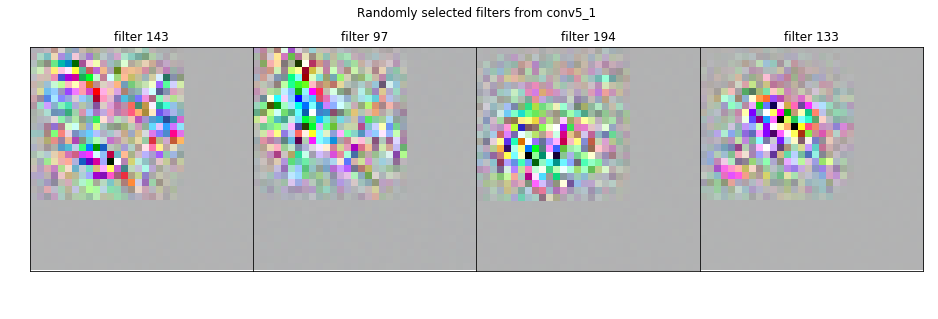

In [0]:
g_ascent.visualize(model.childone.childone.childone.childtwo.encoder[0], title='Randomly selected filters from conv5_1');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Test Loss: 1.2074095726013183

Test Accuracy of airplane: 54.2         (542.0/1000.0)
Test Accuracy of automobile: 53.7         (537.0/1000.0)
Test Accuracy of bird: 51.2         (512.0/1000.0)
Test Accuracy of cat: 38.6         (386.0/1000.0)
Test Accuracy of deer: 46.3         (463.0/1000.0)
Test Accuracy of dog: 59.1         (591.0/1000.0)
Test Accuracy of frog: 78.0         (780.0/1000.0)
Test Accuracy of horse: 59.4         (594.0/1000.0)
Test Accuracy of ship: 66.5         (665.0/1000.0)
Test Accuracy of truck: 71.2         (712.0/1000.0)

Test Accuracy (Overall): 57.82        (5782.0/10000.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

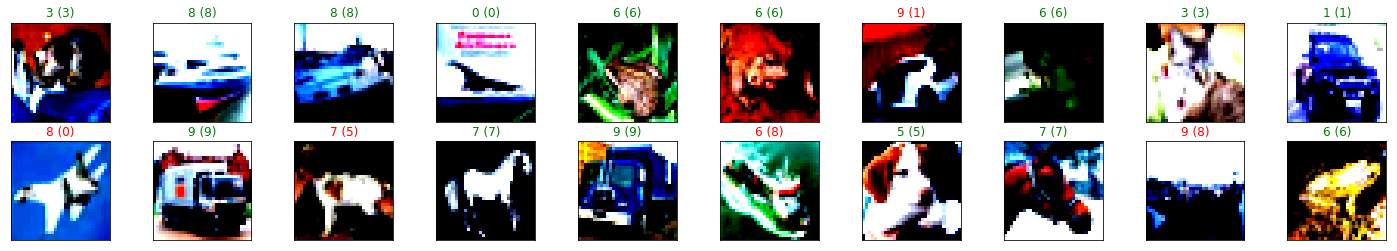

In [0]:
# Test the model
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# model.eval() # prep model for evaluation

for data, target in test_loader:
    # set_trace()
    data, target = data.to('cuda'), target.to('cuda')
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print(f'Test Loss: {test_loss}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {(100 * class_correct[i] / class_total[i])} \
        ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f'\nTest Accuracy (Overall): {(100. * np.sum(class_correct) / np.sum(class_total))} \
       ({np.sum(class_correct)}/{np.sum(class_total)})')

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to('cuda'), labels.to('cuda')
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
# images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Save the model checkpoint
# torch.save(model.state_dict(), 'model_cifar.ckpt')

In [0]:
results
1)
3->16->32->64->128
top, second, middle, bottom

Test Accuracy of airplane: 60.3         (603.0/1000.0)
Test Accuracy of automobile: 53.5         (535.0/1000.0)
Test Accuracy of bird: 33.8         (338.0/1000.0)
Test Accuracy of cat: 36.5         (365.0/1000.0)
Test Accuracy of deer: 55.3         (553.0/1000.0)
Test Accuracy of dog: 54.8         (548.0/1000.0)
Test Accuracy of frog: 68.8         (688.0/1000.0)
Test Accuracy of horse: 65.1         (651.0/1000.0)
Test Accuracy of ship: 59.0         (590.0/1000.0)
Test Accuracy of truck: 68.6         (686.0/1000.0)

Test Accuracy (Overall): 55.57        (5557.0/10000.0)

In [0]:
3->16->32->64->128->256
top, second, middle, AboveBottom, bottom

Test Accuracy of airplane: 55.7         (557.0/1000.0)
Test Accuracy of automobile: 66.7         (667.0/1000.0)
Test Accuracy of bird: 40.1         (401.0/1000.0)
Test Accuracy of cat: 42.8         (428.0/1000.0)
Test Accuracy of deer: 51.9         (519.0/1000.0)
Test Accuracy of dog: 58.6         (586.0/1000.0)
Test Accuracy of frog: 66.4         (664.0/1000.0)
Test Accuracy of horse: 58.7         (587.0/1000.0)
Test Accuracy of ship: 62.6         (626.0/1000.0)
Test Accuracy of truck: 70.8         (708.0/1000.0)

Test Accuracy (Overall): 57.43       (5743.0/10000.0)